# Product Focus

In this notebook, we focus on analyzing customer purchasing behaviors, specifically examining product combinations and trends. By leveraging Market Basket Analysis (MBA) and revenue analysis, our goal is to uncover key insights into product popularity, co-purchasing patterns, and high-revenue items. This will enable us to refine marketing strategies, enhance sales, and improve customer satisfaction.

We will address the following business questions:

- **What are the most common product combinations purchased together?** 
- **How can we utilize these patterns to enhance marketing strategies and increase sales?**

Through this analysis, we aim to provide actionable insights that will help drive targeted promotions and optimize product bundling strategies.

## Libraries

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns



from modules.constants import *
from modules.product_utils import *


## Data Loading

In [2]:


# Loading the datasets
products = pd.read_csv(TBL_PRODUCTS_PATH)
orders = pd.read_csv(TBL_ORDERS_PATH)


## Exploratory Data Analysis (Product Focus)

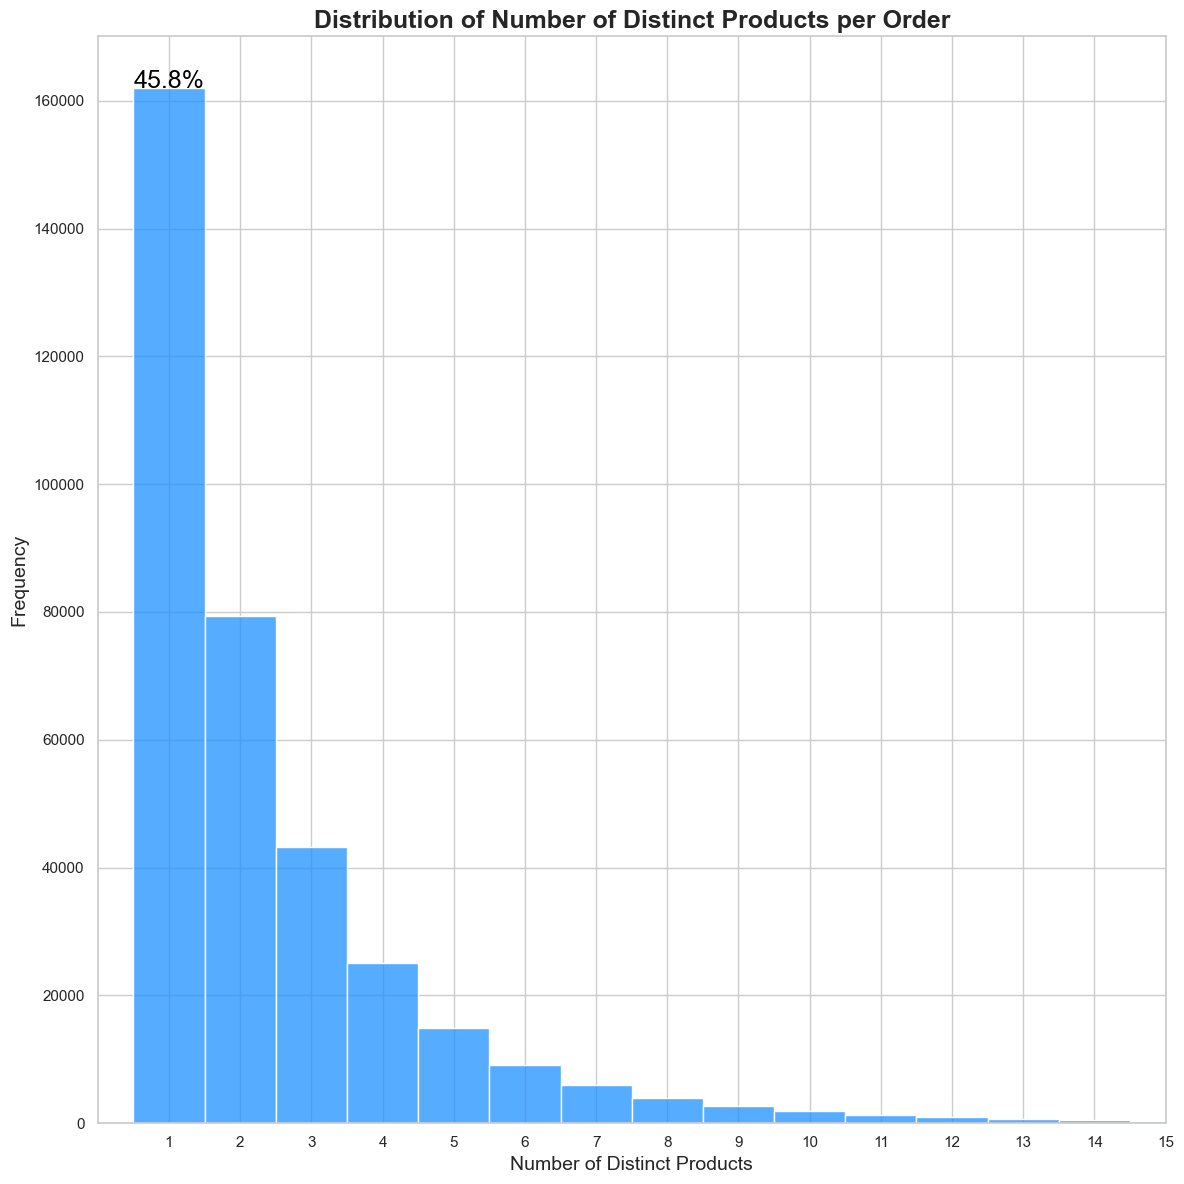

In [3]:
# Filter only purchases (excluding returns)
# Filter only purchases (excluding returns)
purchases = orders[orders['direction'] != -1]


# Group by order and count the number of distinct products in each order
order_product_counts = purchases.groupby('order_id')['product_id'].nunique()

# Setting up the plot
plt.figure(figsize=(12, 12))
sns.set(style="whitegrid")  # Imposta uno stile pulito e professionale

# Create histogram
ax = sns.histplot(order_product_counts, bins=np.arange(1, 16 + 1) - 0.5, kde=False, color='dodgerblue')

# Adding titles and labels for good readability
plt.title('Distribution of Number of Distinct Products per Order', fontsize=18, fontweight='bold')
plt.xlabel('Number of Distinct Products', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adjusting x-axis to show labels for each unit
plt.xticks(np.arange(1, 16 + 1))

# Limiting x-axis to 15
plt.xlim(0, 15)

# Calculating percentage for '1'
total_counts = order_product_counts.value_counts(normalize=True) * 100
perc_1 = total_counts.get(1, 0)  # Get percentage for '1' or default to 0 if not found

# Place a text annotation for the bar of '1'
if 1 in order_product_counts.values:
    ax.text(1, order_product_counts.value_counts().loc[1], f'{perc_1:.1f}%', color='black', ha='center', fontsize = 18)

# Enhancing layout for better viewing
plt.tight_layout()

# Showing the plot
plt.show()

The plot above shows the distribution of the number of distinct products per order. The distribution is heavily skewed to the right, indicating that the majority of orders contain a small number of distinct products. Specifically, the highest frequency is for orders containing one distinct product, with a steep decline as the number of distinct products per order increases. This suggests that most customers tend to purchase a limited variety of products in each order

In [4]:
orders['purchase_datetime'] = pd.to_datetime(orders['purchase_datetime'])

# Filter only purchases (excluding returns)
purchases = orders[orders['direction'] != -1]

# Group by order and count the number of distinct products in each order
order_product_counts = purchases.groupby('order_id')['product_id'].nunique()

# Filter orders with at least two distinct products
multi_product_orders_ids = order_product_counts[order_product_counts > 1].index
multi_product_orders = purchases[purchases['order_id'].isin(multi_product_orders_ids)]


In this step, we filter out orders that contain only a single product. Our focus is on identifying and analyzing associations between different products. Since the majority of orders have only one product, including them would make it difficult to find meaningful associations, especially when looking for frequent itemsets. Additionally, lowering the minimum support threshold to accommodate these single-product orders can become computationally expensive. Therefore, we filter our dataset to include only orders with at least two distinct products to ensure a more robust and manageable analysis.

### Popularity

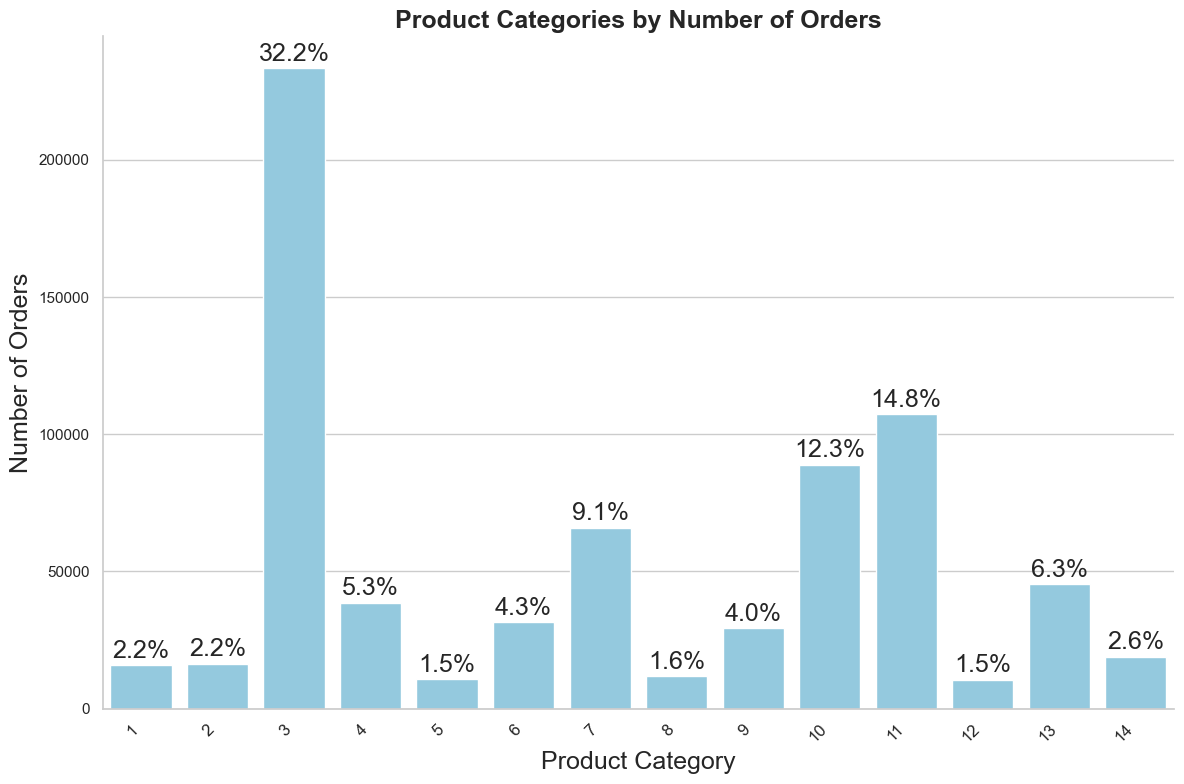

In [5]:
# Count the number of distinct orders in which each product appears
product_order_counts = multi_product_orders.groupby('product_id')['order_id'].nunique().reset_index()
product_order_counts.columns = ['product_id', 'num_orders']

# Merge the order counts with the products dataset to get product categories
product_order_counts = product_order_counts.merge(products, on='product_id')

# Calculate the number of distinct orders for each product category
category_order_counts = product_order_counts.groupby('product_class')['num_orders'].sum().reset_index()

# Sort the product categories by the number of distinct orders in descending order
sorted_category_order_counts = category_order_counts.sort_values(by='num_orders', ascending=False)

# Display the top 10 product categories by number of distinct orders
top_order_categories = sorted_category_order_counts.head(10)

# Supponendo che 'sorted_category_order_counts' sia già definito e contenga i dati necessari
category_order_counts['percentage'] = category_order_counts['num_orders'] / category_order_counts['num_orders'].sum() * 100

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Stile pulito e professionale

# Creare il barplot con un colore uniforme
ax = sns.barplot(
    data=category_order_counts,
    x='product_class',
    y='num_orders',
    color='skyblue'  # Colore uniforme per evitare confusioni
)

# Aggiungi titoli e etichette
plt.title('Product Categories by Number of Orders', fontsize=18, fontweight='bold')
plt.xlabel('Product Category', fontsize=18)
plt.ylabel('Number of Orders', fontsize=18)

# Ruotare le etichette dell'asse x per migliorare la leggibilità
plt.xticks(rotation=45, ha='right', fontsize=12)

# Aggiungere annotazioni con le percentuali sulle barre
for i, p in enumerate(ax.patches):
    percentage = category_order_counts['percentage'].iloc[i]
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=18)
# Pulire i bordi per un look più pulito
sns.despine()

# Mostra il grafico con un layout ottimizzato
plt.tight_layout()
plt.show()

This bar chart illustrates the number of transactions per product category. The x-axis represents different product categories, while the y-axis shows the number of sales. From the chart, it is evident that Category 3 has the highest number of transactions, significantly surpassing all other categories. Other notable categories with a high number of sales include Categories 10, 11, and 4. In contrast, Categories 1, 2, 5, 6, 8, 9, 12, and 14 have relatively lower transaction counts. This distribution highlights the varying popularity and sales performance across different product categories.

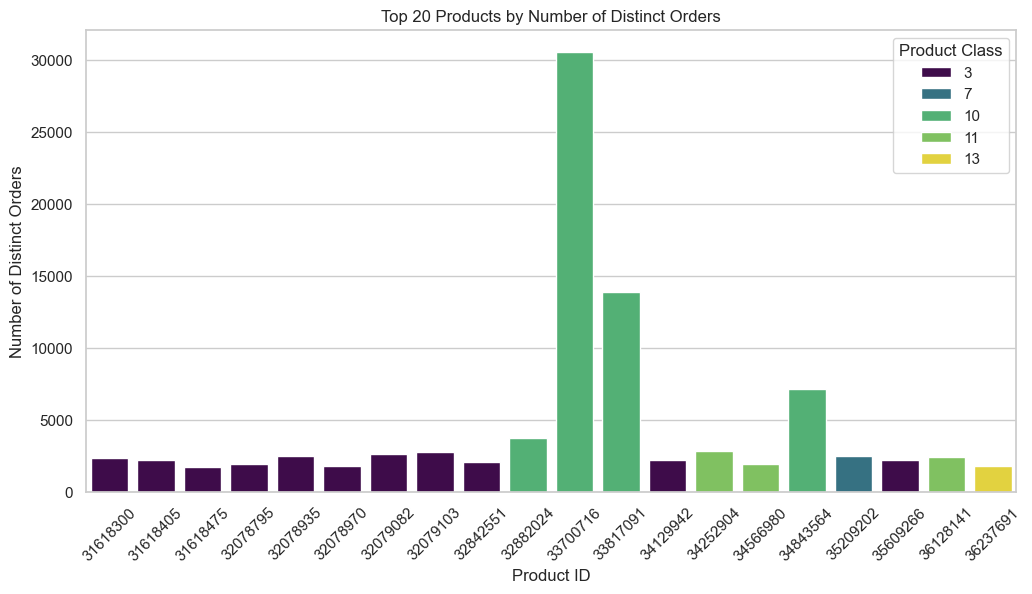

In [6]:
# Calculate the number of sales for each product
# Count the number of distinct orders in which each product appears
product_order_counts = multi_product_orders.groupby('product_id')['order_id'].nunique().reset_index()
product_order_counts.columns = ['product_id', 'num_orders']

# Merge with the products dataframe to get the product_class
product_order_counts = pd.merge(product_order_counts, products[['product_id', 'product_class']], on='product_id')

# Sort products by number of distinct orders in descending order
product_order_counts = product_order_counts.sort_values(by='num_orders', ascending=False)

# Display the top 20 products by number of distinct orders
top_products = product_order_counts.head(20)

# Create the plot, coloring by product_class
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products, x='product_id', y='num_orders', hue='product_class', palette='viridis')
plt.title('Top 20 Products by Number of Distinct Orders')
plt.xlabel('Product ID')
plt.ylabel('Number of Distinct Orders')
plt.xticks(rotation=45)
plt.legend(title='Product Class')
plt.show()


When examining the top 20 products by the number of distinct orders, several observations align with the product class distribution:
- **Product ID 33700716**, belonging to **Product Class 10**, dominates with over 30,000 distinct orders. This suggests that specific products within Product Class 10 are driving a significant number of orders.
- Other products from **Product Classes 10 and 11** (e.g., `33817091`, `3288024`, and `34843564`) also appear frequently in the top 20, reinforcing the high transaction volume observed in the distribution plot.

#### Observations:
- **Product Class 10** has a few products that are extremely popular, driving a high number of distinct orders. This indicates a strong preference for certain products within this class.
- Despite **Product Class 3** having the highest overall number of transactions, it does not feature prominently in the top 20 products by distinct orders. This suggests that while Class 3 products are purchased frequently, the purchases might be more evenly distributed across a broader range of products within this class.
- The high number of distinct orders for specific products in **Product Classes 10 and 11** indicates that these classes have certain products with strong customer loyalty or preference, driving repeat purchases.

These insights suggest that Product Classes 10 and 11 have standout products that significantly contribute to their popularity, while Product Class 3 has a wider range of frequently purchased products. 

### Most monetary

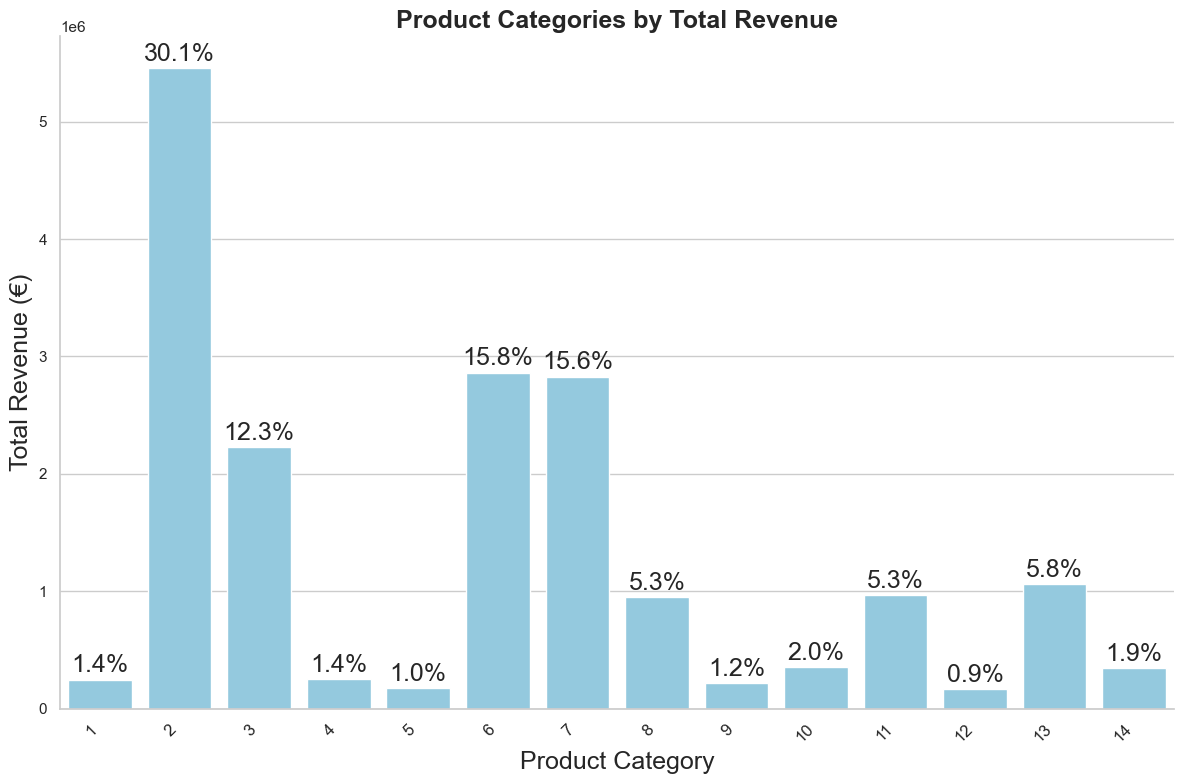

In [7]:
# Adding a gross revenue column to the orders dataset
multi_product_orders['gross_revenue'] = multi_product_orders['gross_price'] - multi_product_orders['price_reduction']

# Calculating the total gross revenue for each product
product_revenue = multi_product_orders.groupby('product_id')['gross_revenue'].sum().reset_index()

# Merging the product revenue with the products dataset to get product categories
product_revenue = product_revenue.merge(products, on='product_id')

# Calculating the total revenue for each product category
category_revenue = product_revenue.groupby('product_class')['gross_revenue'].sum().reset_index()

# Sorting the product categories by total revenue in descending order
sorted_category_revenue = category_revenue.sort_values(by='gross_revenue', ascending=False)

# Calcolo delle percentuali del totale ricavi
category_revenue['percentage'] = category_revenue['gross_revenue'] / category_revenue['gross_revenue'].sum() * 100

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Stile pulito e professionale

# Creazione del barplot con un colore uniforme
ax = sns.barplot(
    data=category_revenue,
    x='product_class',
    y='gross_revenue',
    color='skyblue'  # Colore uniforme per evitare confusioni
)

# Aggiungere titoli e etichette
plt.title('Product Categories by Total Revenue', fontsize=18, fontweight='bold')
plt.xlabel('Product Category', fontsize=18)
plt.ylabel('Total Revenue (€)', fontsize=18)

# Ruotare le etichette dell'asse x per migliorare la leggibilità
plt.xticks(rotation=45, ha='right', fontsize=12)

# Aggiungere annotazioni con le percentuali sulle barre
for i, p in enumerate(ax.patches):
    percentage = category_revenue['percentage'].iloc[i]
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=18)

# Pulizia dei bordi per un look più pulito
sns.despine()

# Mostra il grafico con un layout ottimizzato
plt.tight_layout()
plt.show()


This plot shows the total revenue generated by each product category. Several key insights can be drawn from this visualization:

1. **Product Category 2**: This category generates the highest total revenue, exceeding €5 million. Despite not being the category with the highest number of transactions, its high revenue indicates that the products in this category are likely higher priced or have higher margins.

2. **Product Categories 6 and 7**: Both of these categories show substantial total revenues, each generating over €3 million. This aligns with the earlier observation that products in these categories appear frequently in the top products by the number of distinct orders. It suggests that these categories have popular products that are driving significant sales volume.

3. **Product Category 3**: While this category had the highest number of transactions, its total revenue is comparatively lower. This indicates that the products in this category might have lower prices or lower margins compared to categories 2, 6, and 7.

4. **Product Categories 11 and 13**: These categories also contribute significantly to the total revenue, reflecting their popularity as observed in the top products by the number of distinct orders. Their presence in both high transaction counts and revenue suggests a balanced combination of product popularity and pricing.

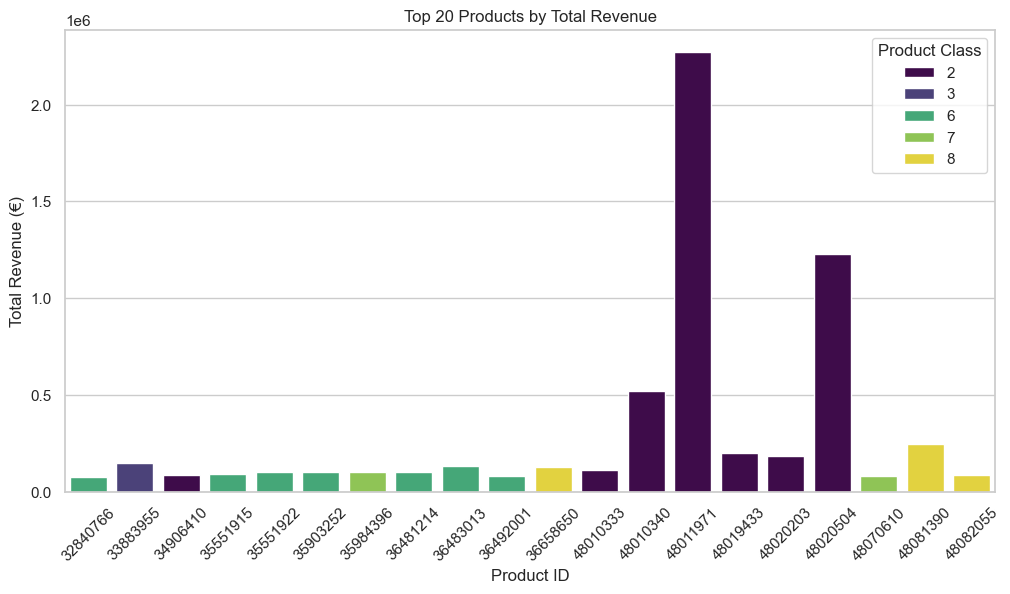

In [8]:
product_revenue = multi_product_orders.groupby('product_id')['gross_revenue'].sum().reset_index()

# Merge with the products dataframe to get the product_class
product_revenue = pd.merge(product_revenue, products[['product_id', 'product_class']], on='product_id')

# Sort products by total revenue in descending order
sorted_product_revenue = product_revenue.sort_values(by='gross_revenue', ascending=False)

# Display the top 20 products by total revenue
top_revenue_products = sorted_product_revenue.head(20)

# Create the plot, coloring by product_class
plt.figure(figsize=(12, 6))
sns.barplot(data=top_revenue_products, x='product_id', y='gross_revenue', hue='product_class', palette='viridis')
plt.title('Top 20 Products by Total Revenue')
plt.xlabel('Product ID')
plt.ylabel('Total Revenue (€)')
plt.xticks(rotation=45)
plt.legend(title='Product Class')
plt.show()


This plot illustrates the top 20 products by total revenue, categorized by their product class. Several notable insights can be drawn:

1. **Dominance of Product Class 2**:
    - Products from Product Class 2 dominate the top revenue-generating products, with two standout products (IDs 4801971 and 48020504) contributing significantly to the revenue. This aligns with the earlier observation that Product Category 2 leads in total revenue, indicating that specific high-performing products are driving this trend.

2. **Product Class Distribution**:
    - While Product Class 2 leads in revenue, other classes such as 6, 7, and 8 also have products in the top 20. This diversity highlights the importance of multiple product classes in revenue generation, not just the leading category.

3. **Revenue Spread**:
    - There is a significant gap between the top few products and the rest. The top product from Product Class 2 generate more than €2 million, while the remaining products generate much less. This suggests that a few key products are crucial to the company's revenue.

## Market Basket Analysis

### Rules Generation

#### All Categories

In [9]:
all_rules = create_association_rules_including_categories(multi_product_orders, products)
print("Shape: ", all_rules.shape)
sorted_rules = all_rules.sort_values(by='lift', ascending=False)

sorted_rules.head()

Calculating frequent itemsets:   0%|          | 0/2000 [00:00<?, ?it/s]

Processing 96 combinations | Sampling itemset size 32

Calculating frequent itemsets: 100%|██████████| 2000/2000 [00:02<00:00, 826.05it/s]


Processing 20 combinations | Sampling itemset size 4


Generating association rules: 100%|██████████| 311/311 [00:00<?, ?it/s]

Shape:  (47, 11)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,num_transactions
10,(36298416),(36298381),0.003943,0.006437,0.003031,0.768519,119.393151,0.003005,4.292193,0.995550,581.0
8,(36298416),(36298353),0.003943,0.007407,0.003432,0.870370,117.504903,0.003403,7.657145,0.995415,658.0
2,(36298206),(36298122),0.004825,0.007011,0.003964,0.821622,117.196010,0.003931,5.566758,0.996274,760.0
7,(36298395),(36298353),0.004225,0.007407,0.003662,0.866667,117.004883,0.003631,7.444447,0.995660,702.0
9,(36298395),(36298381),0.004225,0.006437,0.003177,0.751852,116.803902,0.003150,4.003911,0.995645,609.0


The table displays the top association rules generated from the dataset, providing insights into the relationships between different products purchased together. The Apriori algorithm was then applied to find frequent itemsets with a minimum support of 0.003. 

After identifying the frequent itemsets, we used the confidence metric to generate strong association rules with a minimum confidence of 0.75. These rules were further filtered based on lift to ensure meaningful associations. The support indicates the proportion of transactions that include both the antecedent and consequent itemsets, while confidence measures the likelihood that the consequent items are purchased when the antecedent items are purchased. Lift, being greater than 1, indicates a strong positive association between the itemsets.

For example, the rule with antecedents (31047415) and consequents (31047464) has a lift of 114.885245, suggesting a very strong association. This means that when product 31047415 is purchased, product 31047464 is very likely to be purchased as well.

In [10]:

analyze_class_associations(all_rules, products)

,antecedent_classes,consequent_classes,frequency
0,"(3,)","(3,)",47


The result from the analyze_class_associations function indicates that the only frequent association found between product classes involves class 3. Specifically, the most common antecedent and consequent class in the association rules is class 3, appearing together 47 times. This suggests that products within class 3 are frequently purchased together.

Previously, we observed that category 3 was the most popular category. Due to this, we might have excluded interesting association rules from other categories that were potentially filtered out because of their relatively low support. We cannot lower the minimum support further to try to include these potentially lost rules because it would become computationally very heavy. Therefore, we will proceed by removing category 3 and reapplying the algorithm to uncover associations from the remaining categories.

#### Rule search without category 3

In [11]:
all_categories = products['product_class'].unique().tolist()
included_categories = [category for category in all_categories if category != 3]
rules_without_popular_category = create_association_rules_including_categories(multi_product_orders, products, included_categories)
print("Shape: ", rules_without_popular_category.shape)
sorted_rules_without_popular_category = rules_without_popular_category.sort_values(by='lift', ascending=False)

sorted_rules_without_popular_category.head()

Calculating frequent itemsets: 100%|██████████| 1448/1448 [00:01<00:00, 1265.33it/s]


Processing 6 combinations | Sampling itemset size 2


Generating association rules: 100%|██████████| 164/164 [00:00<00:00, 10523.30it/s]

Shape:  (2, 11)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,num_transactions
0,(35984396),(35984452),0.003318,0.003227,0.00305,0.919244,284.864941,0.003039,12.343020,0.999807,535.0
1,(35984452),(35984396),0.003227,0.003318,0.00305,0.945230,284.864941,0.003039,18.197481,0.999716,535.0


After removing category 3, we found only 2 association rules with a support of 0.003. To uncover more potential associations, we will proceed by lowering the support threshold to 0.001. However, to ensure the strength of these new rules, we will increase the confidence threshold to 0.85.

In [12]:
all_categories = products['product_class'].unique().tolist()
included_categories = [category for category in all_categories if category != 3]
rules_without_popular_category = create_association_rules_including_categories(multi_product_orders, products, included_categories, min_support = 0.001, min_confidence = 0.85)
print("Shape: ", rules_without_popular_category.shape)
sorted_rules_without_popular_category = rules_without_popular_category.sort_values(by='lift', ascending=False)

sorted_rules_without_popular_category.head()

Calculating frequent itemsets:   0%|          | 0/1448 [00:00<?, ?it/s]

Processing 369 combinations | Sampling itemset size 2

Calculating frequent itemsets: 100%|██████████| 1448/1448 [00:04<00:00, 303.60it/s]


Processing 32 combinations | Sampling itemset size 3


Generating association rules: 100%|██████████| 1142/1142 [00:00<?, ?it/s]

Shape:  (41, 11)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,num_transactions
21,(36657901),(36657866),0.001066,0.001072,0.001060,0.994652,927.978951,0.001059,186.799564,0.999989,186.0
20,(36657866),(36657901),0.001072,0.001066,0.001060,0.989362,927.978951,0.001059,93.899782,0.999994,186.0
40,(36658650),"(36658573, 36658615)",0.001089,0.001351,0.001083,0.994764,736.201206,0.001082,190.741918,0.999730,190.0
25,(36658650),(36658573),0.001089,0.001448,0.001083,0.994764,686.927897,0.001082,190.723406,0.999633,190.0
39,"(36658650, 36658615)",(36658573),0.001089,0.001448,0.001083,0.994764,686.927897,0.001082,190.723406,0.999633,190.0


In [13]:
analyze_class_associations(rules_without_popular_category, products)

,antecedent_classes,consequent_classes,frequency
1,"(7,)","(7,)",23
2,"(8,)","(8,)",16
0,"(5,)","(5,)",2


After adjusting the support threshold to 0.001 and increasing the confidence threshold to 0.85, we identified 41 association rules. The top rules exhibit high confidence and lift values, indicating strong associations. For example, the rule with antecedents `34601392` and consequents `34601371` shows a confidence of 96.6% and a lift of 350.79, suggesting a strong relationship between these products.

Upon analyzing the class associations without category 3, we found new frequent associations involving different product classes:

- The most common association is between class 7, appearing together 23 times.
- Class 8 appears frequently together 16 times.
- Class 5 appears together 2 times.

However, it is important to note that we did not find any associations between different product categories. The identified associations are within the same product classes. 


#### High Value Categories

We will now focus on the association rules for the top 3 categories in terms of revenue. By filtering the orders to include only these high-value categories, we aim to uncover significant associations. After filtering, we will apply the Apriori algorithm to identify frequent itemsets, and then use confidence metrics to find the strong association rules among these categories.







In [14]:
included_categories =sorted_category_revenue.product_class.head(3).tolist()
high_values_rules = create_association_rules_including_categories(multi_product_orders, products, included_categories, min_support = 0.001, min_confidence = 0.85)
print("Shape: ", high_values_rules.shape)

sort_high_values_rules = high_values_rules.sort_values(by='lift', ascending=False)

sort_high_values_rules.head()

Calculating frequent itemsets:   0%|          | 0/429 [00:00<?, ?it/s]

Processing 531 combinations | Sampling itemset size 2

Calculating frequent itemsets: 100%|██████████| 429/429 [00:00<00:00, 673.90it/s]


Processing 15 combinations | Sampling itemset size 43


Generating association rules: 100%|██████████| 624/624 [00:00<00:00, 40034.35it/s]

Shape:  (39, 11)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,num_transactions
2,(35254541),(35254534),0.002971,0.003572,0.002782,0.936416,262.142508,0.002772,15.671092,0.999154,162.0
21,"(36136240, 34478094)",(36136366),0.001219,0.004517,0.001116,0.915493,202.689445,0.001111,11.779885,0.996281,65.0
14,(36605450),(36605443),0.003795,0.004654,0.003521,0.927602,199.307742,0.003503,13.748215,0.998773,205.0
38,"(35156184, 35156121, 35156163)",(35156170),0.001374,0.005187,0.001357,0.987500,190.397848,0.001350,79.585079,0.996116,79.0
28,"(35156184, 35761110)",(35156170),0.001082,0.005187,0.001065,0.984127,189.747503,0.001059,62.673250,0.995807,62.0


In [15]:
analyze_class_associations(high_values_rules, products)


,antecedent_classes,consequent_classes,frequency
1,"(7,)","(7,)",38
0,"(6,)","(6,)",1


After filtering the orders to include only the top three revenue-generating categories and applying the Apriori algorithm with a minimum support of 0.001 and a minimum confidence of 0.85, we obtained the following results:

1. **Dominance of Within-Category Associations**:
    - Most of the association rules found involve products within the same category. Specifically, category 7 shows a high frequency of within-category associations, with 38 occurrences, and category 6 has one within-category association. This indicates that products within the same category are frequently purchased together.

2. **Lack of Cross-Category Associations**:
    - The absence of cross-category associations suggests that customers tend to purchase products from the same category rather than mixing products from different categories. This trend might limit the discovery of interesting inter-category relationships and indicates a need for strategies that encourage cross-category purchases.

3. **No Associations Involving Category 2**:
    - Notably, we did not find any associations involving category 2, which is the category with the highest revenue. Despite its significant contribution to total revenue, products from category 2 do not frequently appear in the same basket as other products. This could imply that category 2 products are often purchased alone or with other less frequent combinations, highlighting an opportunity to explore and promote complementary products for category 2.



### Business Insight

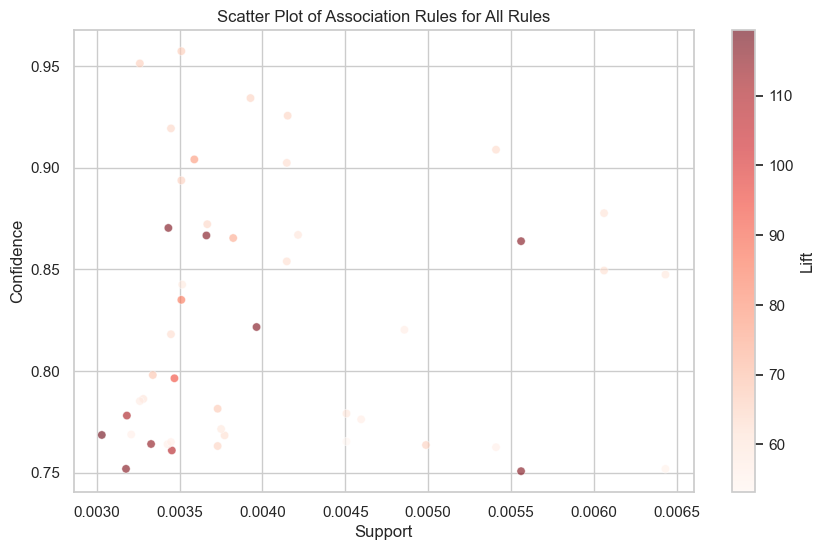

In [16]:
get_scatter_plot(all_rules, title = "Scatter Plot of Association Rules for All Rules")

The scatter plot of all association rules reveals several key insights primarily based on lift values. The lift values, indicated by the color intensity, range from approximately 60 to over 110, suggesting varying degrees of association strength between the itemsets.

High-lift rules are concentrated in areas with lower support, particularly around the 0.0030 to 0.0040 range, yet these rules often have high confidence, indicating that while they may not occur as frequently, they are strong indicators when they do occur. These high-lift rules, found mostly at the lower support levels, can be crucial for identifying significant but less common purchasing patterns.

In contrast, rules with higher support (above 0.0045) tend to have lower lift values. Although these rules are more common, the strength of the association between their itemsets is comparatively weaker.


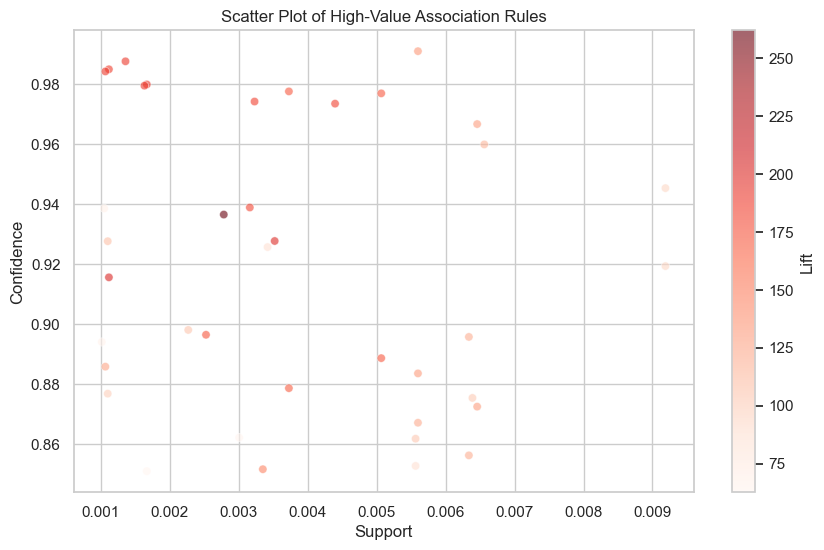

In [17]:
get_scatter_plot(high_values_rules, title = "Scatter Plot of High-Value Association Rules")

The scatter plot of association rules for the top 3 product categories in terms of revenue reveals some key insights based on lift values. The lift values, represented by the color intensity, range widely, with many rules showing exceptionally high lift values, some even surpassing 200. This high lift indicates strong and significant associations between the items within these categories, meaning that the occurrence of the antecedent product greatly increases the likelihood of the consequent product being purchased.

Observing the position of these rules in the plane, we notice that rules with high support and confidence tend to have slightly lower lift values, generally ranging between 75 and 150. Conversely, rules located in the lower support range, but with high confidence, display the highest lift values, exceeding 200.


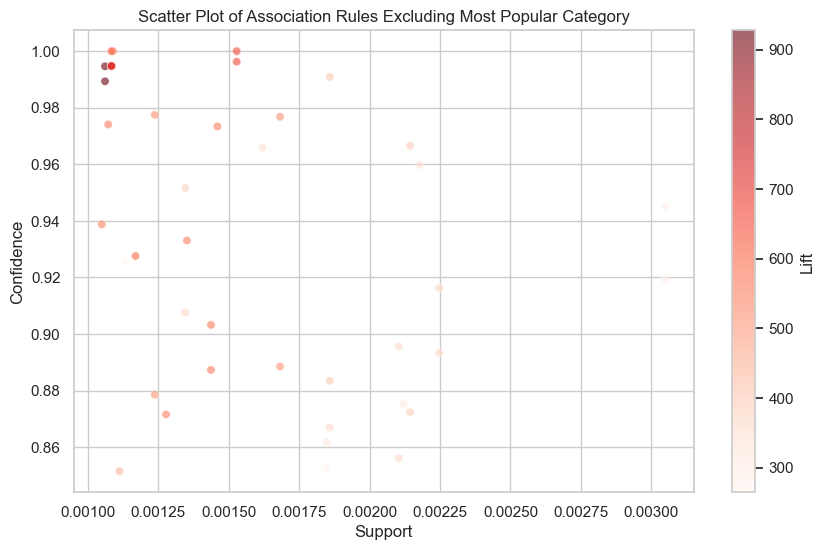

In [18]:
get_scatter_plot(rules_without_popular_category, title = "Scatter Plot of Association Rules Excluding Most Popular Category")

The scatter plot of association rules without the most popular category reveals several key insights based on lift values. The lift values, indicated by the color intensity, range from approximately 300 to over 900, highlighting significant variations in the strength of associations.

High-lift rules, represented by darker points, are predominantly located in the region with lower support, around the 0.0010 to 0.0020 range, but these rules often exhibit high confidence, approaching 1.0. This suggests that while these rules do not occur very frequently, they represent very strong associations when they do. These high-lift, high-confidence rules are critical for identifying strong but infrequent patterns in the data.

In contrast, as support increases beyond 0.0025, the lift values tend to decrease, indicating that while these rules are more commonly observed, the associations between itemsets are weaker. This trend demonstrates a trade-off between the frequency of occurrence and the strength of the association.

Overall, removing the most popular category has allowed the identification of several strong association rules with very high lift and confidence but low support. This suggests valuable but less frequent patterns that could be important for targeted marketing strategies and inventory management.


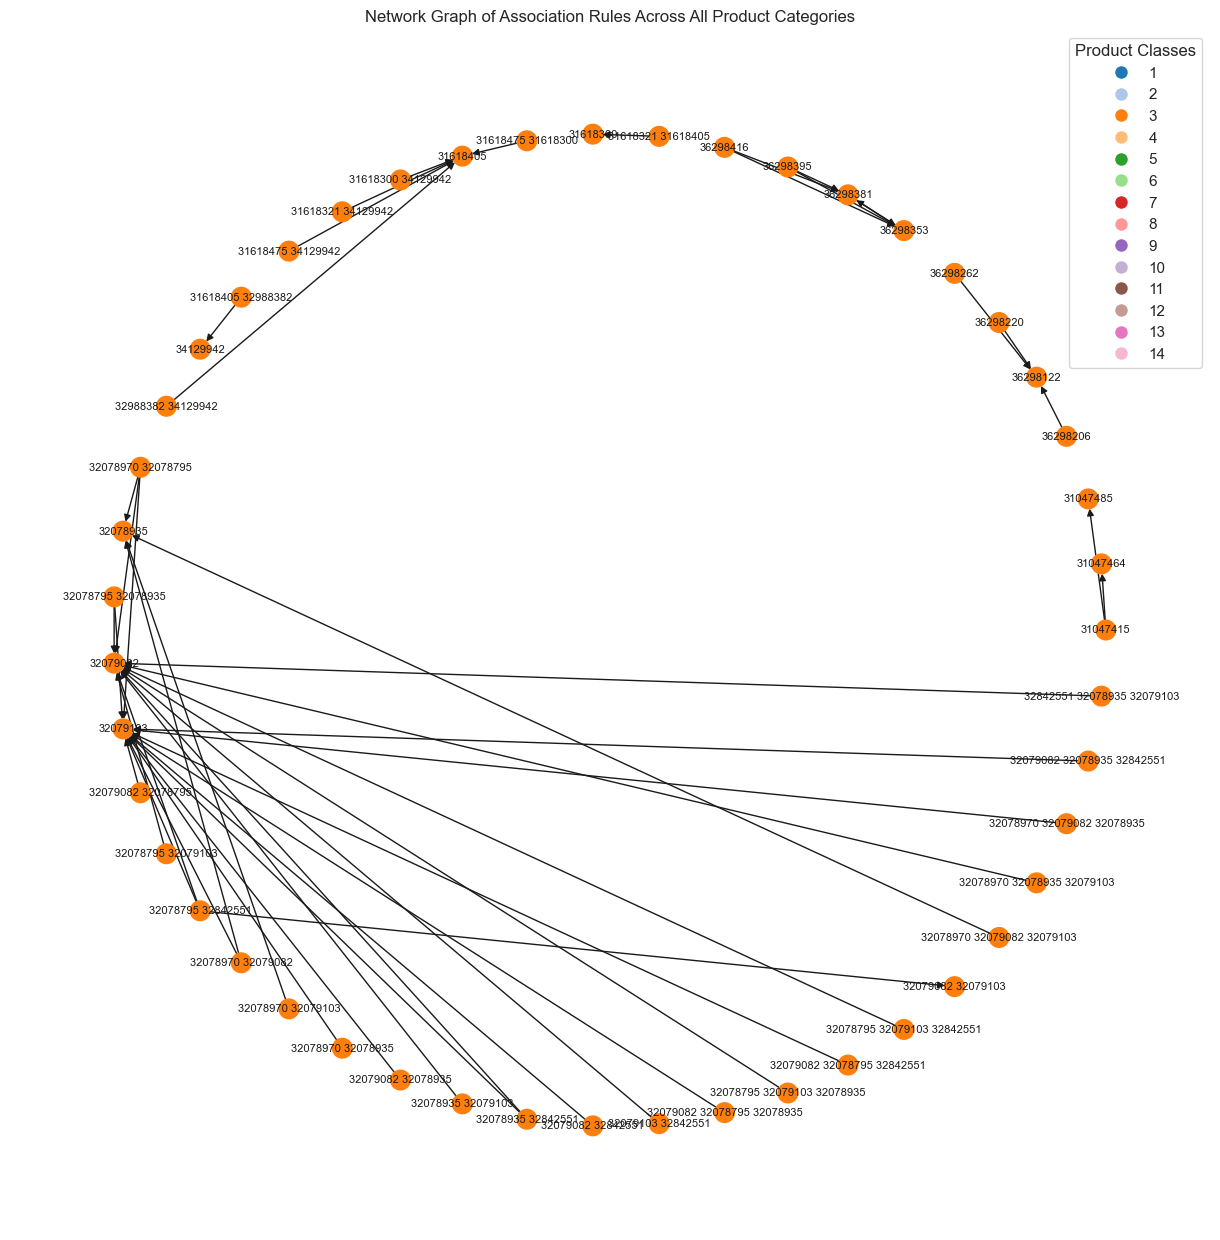

In [19]:
plot_association_rules_graph(all_rules, products, title = "Network Graph of Association Rules Across All Product Categories")


The network graph visualizes association rules among products, with nodes representing products and edges representing the rules. All nodes are colored orange, indicating that they belong exclusively to Product Class 3. This dominance underscores previous findings about the popularity of this class.

Notably, certain products act as central hubs, appearing as the consequent in multiple rules. These high-consequence products are frequently purchased following various antecedent products, indicating their crucial role in customer buying patterns. This suggests that these products could be key targets for marketing strategies and promotions.


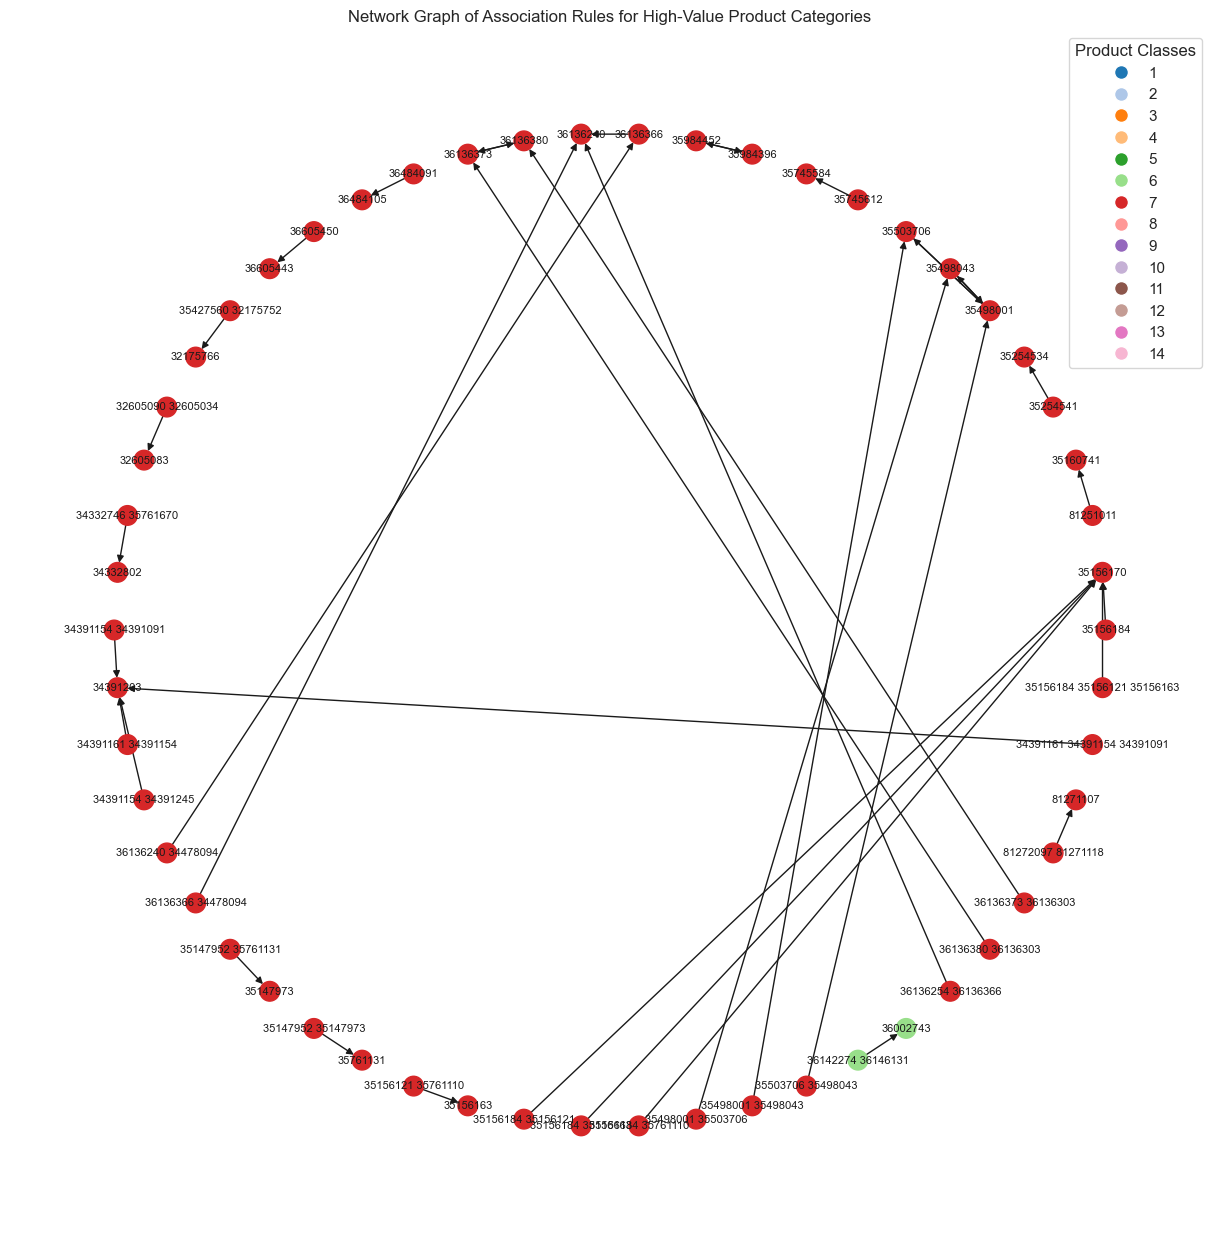

In [20]:
plot_association_rules_graph(high_values_rules, products, title = "Network Graph of Association Rules for High-Value Product Categories")


The network graph of high_value_rules reveals associations among products from the top revenue-generating categories. As previously observed, only categories 6 and 7 are present, while the most profitable category, 2, does not have any significant associations. This absence suggests that products from category 2 are not frequently co-purchased with other products, highlighting potential gaps in cross-selling opportunities.

Most of the associations are unidirectional, indicating straightforward relationships between antecedent and consequent products. Unlike the graph of all_rules, we do not see any products that serve as the consequent for many different antecedents. This suggests a more evenly distributed set of associations, without dominant central hubs, pointing to a more varied purchasing behavior among these high-value categories.


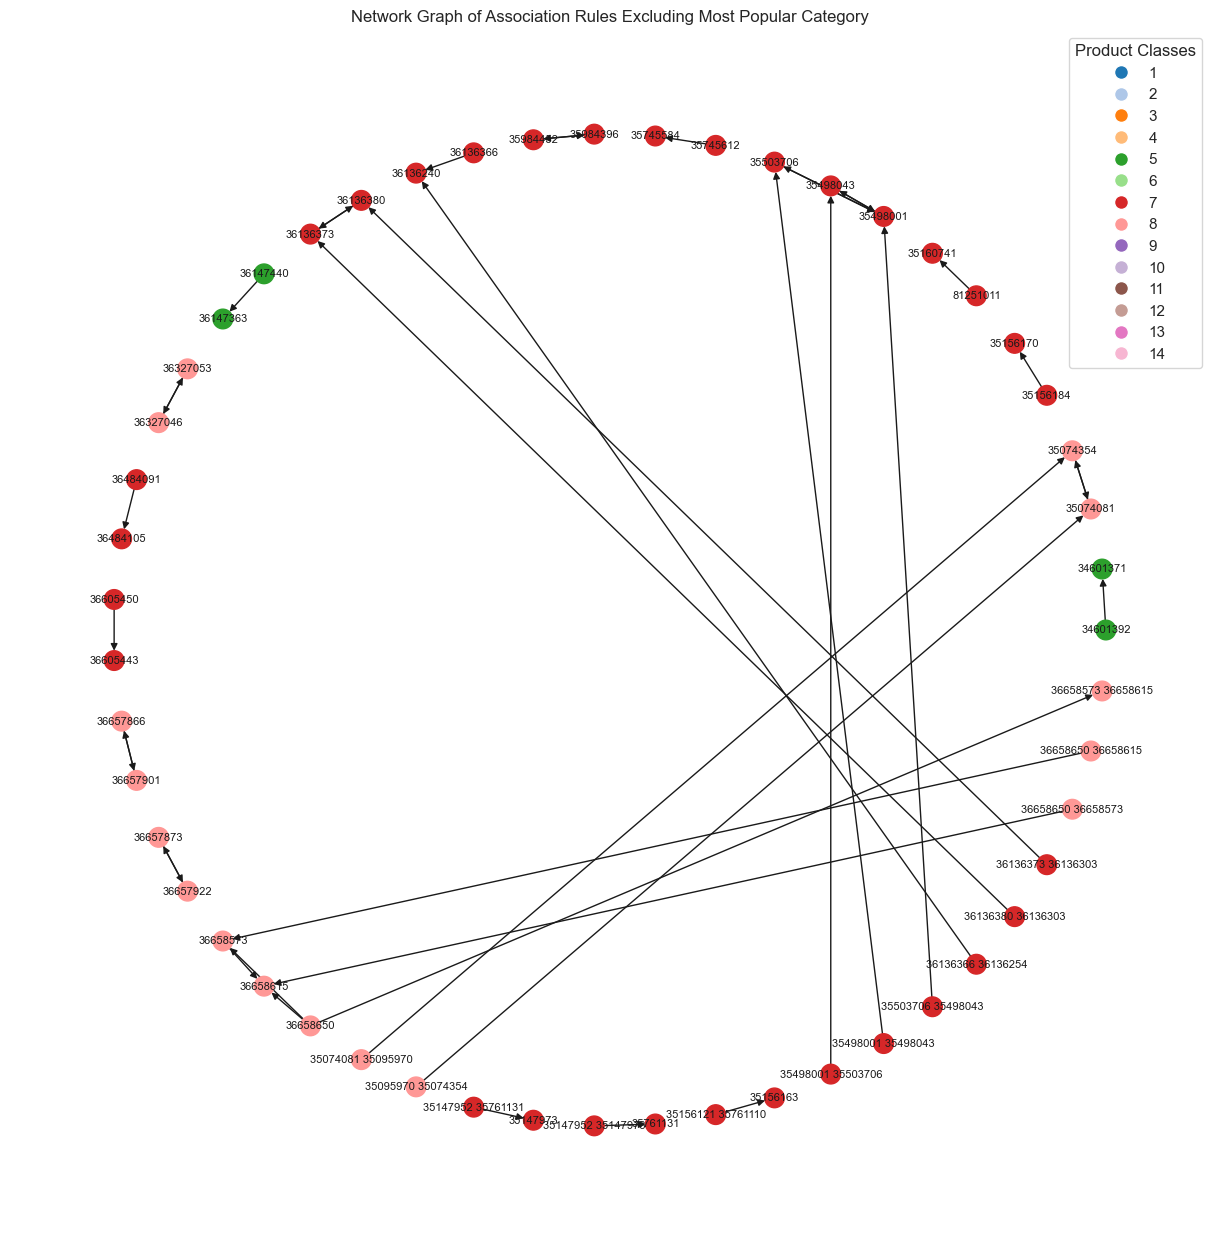

In [21]:
plot_association_rules_graph(rules_without_popular_category, products, title = "Network Graph of Association Rules Excluding Most Popular Category")


The network graph of association rules without including category 3 reveals several insights. Notably, all associations occur within the same product category, indicating that products from different categories are not frequently purchased together. 

There are numerous associations within category 7, which is highly profitable and second only to category 2 in terms of revenue. This suggests strong co-purchasing behavior within category 7, highlighting potential areas for targeted marketing and bundling strategies. 

## Action Steps

### Targeted Marketing for Category 7

Launch an email campaign targeting frequent buyers from Category 7, offering a 10% discount on next purchases that include complementary items from the same category. Highlight specific combinations that have shown frequent co-purchases in the 23 identified rules to encourage higher transaction values.

### Promotional Campaign for Category 8

Implement a social media advertising campaign for Category 8, focusing on the unique product combinations found in the 16 association rules. Promote a 15% discount on these bundles to increase visibility and attract more buyers, enhancing both the popularity and profitability of this category.

### Profitability Enhancement for Category 3

Use the 47 association rules identified to promote premium products within Category 3, which despite its high popularity, ranks lower in profitability. Offer a 5% discount on high-margin items within this category when bundled with more frequently purchased items, aiming to enhance overall profitability through upselling
